<a href="https://colab.research.google.com/github/anapaaula/cnn-passaros/blob/main/Classifying_Birds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise Experimental Comparativa entre Diferentes Modelos de ML para Classificação de Imagens de Aves


O problema abordado no presente notebook é o de classificação de imagens de passáros baseados no dataset https://www.kaggle.com/datasets/ichhadhari/indian-birds/data.
O dataset consiste em imagens de 25 espécies de aves da Índia.

Uma Rede Neural Convolucional foi desenvolvida como baseline para classificar as espécies de aves do dataset, e foram adicionadas técnicas de regularização para reduzir o overfitting do modelo.



# Conhecendo o dataset

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import random
from PIL import Image
import tensorflow as tf
from IPython import display
from tensorflow import keras
import seaborn as sns
from sklearn.metrics import confusion_matrix
from google.colab import files
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from tensorflow.keras import layers, models, optimizers


In [ ]:
! pip install -q kaggle

In [ ]:
! kaggle datasets download -d ichhadhari/indian-birds

Dataset URL: https://www.kaggle.com/datasets/ichhadhari/indian-birds
License(s): CC0-1.0
100% 5.28G/5.30G [00:23<00:00, 229MB/s]
100% 5.30G/5.30G [00:23<00:00, 240MB/s]


In [ ]:
! unzip indian-birds.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: Birds_25/valid/Forest-Wagtail/Forest-Wagtail_162.jpg  
  inflating: Birds_25/valid/Forest-Wagtail/Forest-Wagtail_167.jpg  
  inflating: Birds_25/valid/Forest-Wagtail/Forest-Wagtail_168.jpg  
  inflating: Birds_25/valid/Forest-Wagtail/Forest-Wagtail_17.jpg  
  inflating: Birds_25/valid/Forest-Wagtail/Forest-Wagtail_171.jpg  
  inflating: Birds_25/valid/Forest-Wagtail/Forest-Wagtail_176.jpg  
  inflating: Birds_25/valid/Forest-Wagtail/Forest-Wagtail_177.jpg  
  inflating: Birds_25/valid/Forest-Wagtail/Forest-Wagtail_182.jpg  
  inflating: Birds_25/valid/Forest-Wagtail/Forest-Wagtail_184.jpg  
  inflating: Birds_25/valid/Forest-Wagtail/Forest-Wagtail_189.jpg  
  inflating: Birds_25/valid/Forest-Wagtail/Forest-Wagtail_204.jpg  
  inflating: Birds_25/valid/Forest-Wagtail/Forest-Wagtail_21.jpg  
  inflating: Birds_25/valid/Forest-Wagtail/Forest-Wagtail_219.jpg  
  inflating: Birds_25/valid/Forest-Wagtail/Forest-Wagtail_2

In [ ]:
path_dataset_train = "/content/Birds_25/train"
path_dataset_valid = "/content/Birds_25/valid"

In [ ]:
os.listdir(path_dataset_train) == os.listdir(path_dataset_valid)

True

# Análise Exploratória dos Dados (EDA)

In [ ]:
def extract_class_from_path(pathname):
    return pathname.split("/")[-2].split(".")[-1]

In [ ]:
classnames = set()
for dir in os.listdir(path_dataset_train):
    classnames.add(dir.split(".")[-1])

In [ ]:
count_class = {k: 0 for k in classnames}

for root, _, files in os.walk(path_dataset_train):
    for file_ in files:
        class_file = extract_class_from_path(os.path.join(root, file_))
        count_class[class_file] +=1



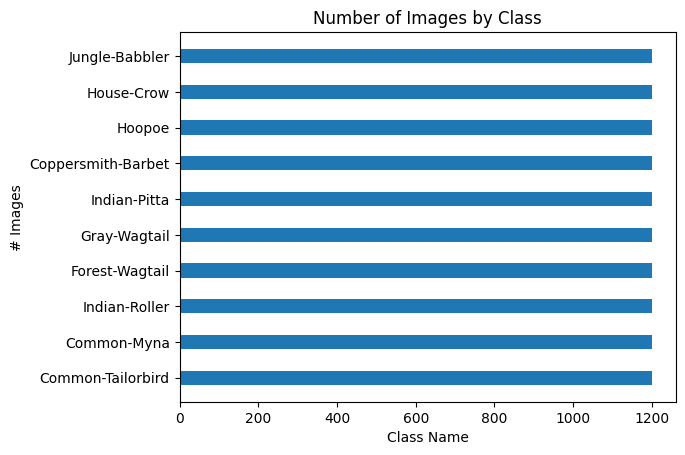

In [ ]:
plt.barh(list(count_class.keys())[0:10], list(count_class.values())[0:10], height = .4);
plt.title("Number of Images by Class");
plt.xlabel('Class Name');
plt.ylabel('# Images');

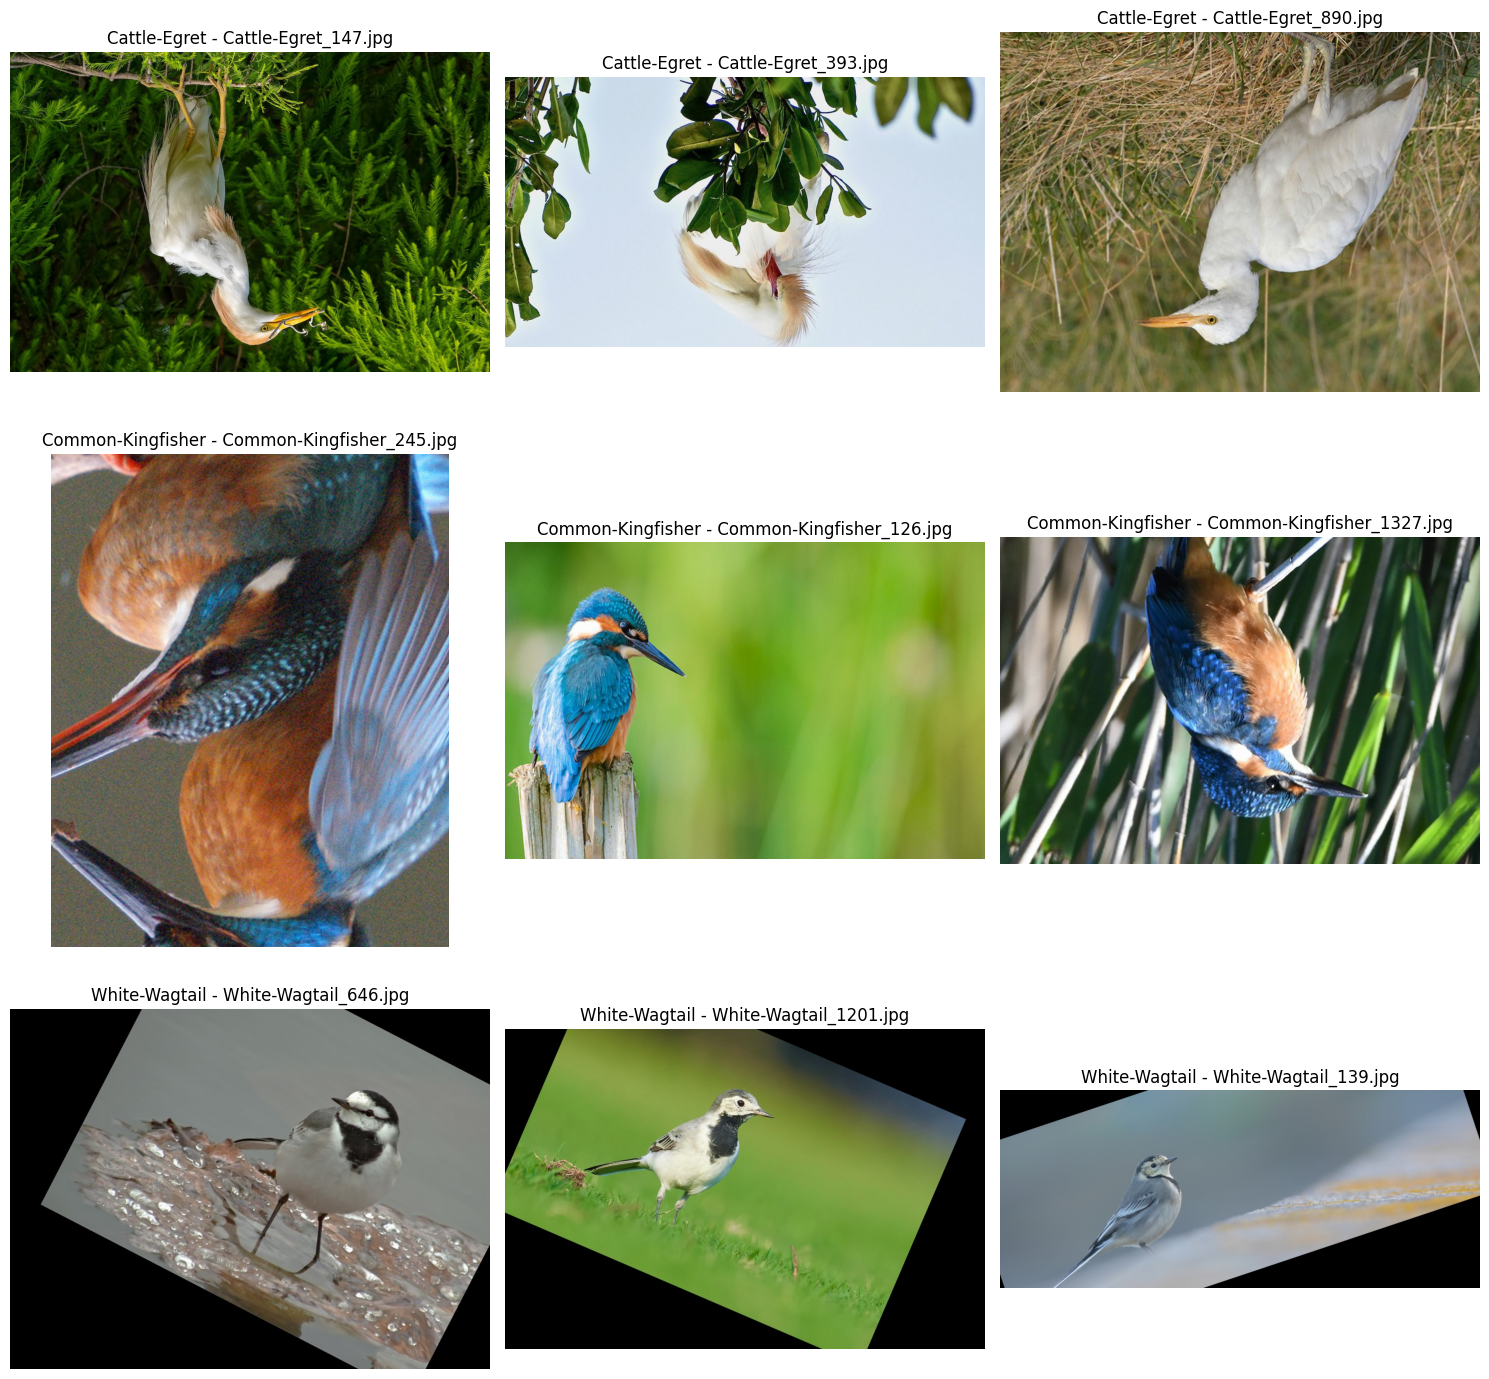

In [ ]:
classes = ['Cattle-Egret', 'Common-Kingfisher', 'White-Wagtail']

num_imagens = 3

fig, axs = plt.subplots(len(classes), num_imagens, figsize=(15, 5 * len(classes)))

for i, classe in enumerate(classes):
    classe_dir = os.path.join(path_dataset_train, classe)
    imagens = os.listdir(classe_dir)
    amostra = random.sample(imagens, num_imagens)

    for j, img_nome in enumerate(amostra):
        img_path = os.path.join(classe_dir, img_nome)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set_title(f'{classe} - {img_nome}')
        axs[i, j].axis('off')


plt.tight_layout()
plt.show()

Gráfico para explorar as dimensões das imagens do conjunto de dados de treinamento e identificar se há uma distribuição padrão ou se existe muita variação nas dimensões.

In [ ]:
class_paths = [path_dataset_train + '/' + f for f in os.listdir(path_dataset_train)]
filelist = []

for class_path in class_paths:
  filelist.extend([class_path + '/' + f for f in os.listdir(class_path)])

widths = []
heights = []
for img_path in filelist:
  img = Image.open(img_path)
  h,w = img.size
  widths.append(w)
  heights.append(h)


plt.figure(figsize=(8, 6))
plt.scatter(widths, heights, alpha=0.5)
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Scatter Plot of Image Dimensions")
plt.show()


# Funções e úteis

## Carregando o Dataset

In [ ]:
image_size = (180, 180)
batch_size = 64

train_ds = tf.keras.utils.image_dataset_from_directory(
    path_dataset_train,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    path_dataset_valid,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 30000 files belonging to 25 classes.
Found 7500 files belonging to 25 classes.


In [ ]:
num_batches_train = 9
num_batches_val = 4

train_ds_limited = train_ds.take(num_batches_train)
val_ds_limited = val_ds.take(num_batches_val)

## Carregando imagens

In [ ]:
def load_image_files(container_path, dimension=(64, 64), max_files = 12000):

    image_dir = Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]

    train_img = []
    target = []

    count = 0
    for label, folder in enumerate(folders):
        for file_ in folder.iterdir():
            if count > max_files:
                break
            with Image.open(file_) as img:
                img_resized = img.resize(dimension).convert('RGB')
                img_array = np.array(img_resized).flatten()
                img_array = img_array / 255.0
                train_img.append(img_array)
                target.append(label)
            count+=1

    X = np.array(train_img)
    y = np.array(target)

    return X, y

## Função Plot das Curvas de Acurácia e Perda

In [ ]:
def plot_curves(hist):
    accuracy = hist.history["accuracy"]
    val_accuracy = hist.history["val_accuracy"]
    loss = hist.history["loss"]
    val_loss = hist.history["val_loss"]
    epochs = range(1, len(accuracy) + 1)

    plt.plot(epochs, accuracy, "r", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, "r", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()

## Listagem das Classes

In [ ]:
class_names = train_ds.class_names
print("Classes encontradas:", class_names)

Classes encontradas: ['Asian-Green-Bee-Eater', 'Brown-Headed-Barbet', 'Cattle-Egret', 'Common-Kingfisher', 'Common-Myna', 'Common-Rosefinch', 'Common-Tailorbird', 'Coppersmith-Barbet', 'Forest-Wagtail', 'Gray-Wagtail', 'Hoopoe', 'House-Crow', 'Indian-Grey-Hornbill', 'Indian-Peacock', 'Indian-Pitta', 'Indian-Roller', 'Jungle-Babbler', 'Northern-Lapwing', 'Red-Wattled-Lapwing', 'Ruddy-Shelduck', 'Rufous-Treepie', 'Sarus-Crane', 'White-Breasted-Kingfisher', 'White-Breasted-Waterhen', 'White-Wagtail']


## Função Plot da Matriz de Confusão do Modelo

In [ ]:
def plot_matriz_confusao(model, val_ds):
  y_true = []
  y_pred = []

  for images, labels in val_ds:
      y_true.extend(labels.numpy())

      preds = model.predict(images, verbose=0)
      preds_classes = np.argmax(preds, axis=1)


      y_pred.extend(preds_classes)

  y_true = np.array(y_true)
  y_pred = np.array(y_pred)
  cm = confusion_matrix(y_true, y_pred)


  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title('Confusion Matrix')
  plt.show()

# KNN Classifier

## Preparando os Dados

O modelo K-Nearest Neighbors apresentou uma acurácia baixa de 0,18, mesmo após a aplicação de técnicas de redução de dimensionalidade, como a Análise de Componentes Principais (PCA). Esse resultado pode ser atribuído à dificuldade do K-NN em lidar com dados de alta dimensionalidade e complexidade, como imagens, devido à maldição da dimensionalidade. Além disso, o K-NN não capta adequadamente as nuances espaciais das imagens, o que compromete sua capacidade de generalização em tarefas de classificação. No entanto, após o uso da técnica de cross-validation, a acurácia aumentou para 0,43.

Por motivos de limitação de RAM, foi preciso limitar o número de classes do KNN para apenas 10 classes.

In [ ]:
x_train, y_train = load_image_files(path_dataset_train, dimension=(64, 64))
x_test, y_test = load_image_files(path_dataset_valid, dimension=(64,64))

In [ ]:
pca = PCA(n_components=20)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

## Criando o Modelo

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=5, weights='distance')

## Treinando o modelo

In [ ]:
neigh.fit(x_train_pca, y_train)

KNeighborsClassifier(weights='distance')

## Avaliando o Modelo

In [ ]:
y_pred = neigh.predict(x_test_pca)

accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.18213333333333334


In [ ]:
cv_scores = cross_val_score(neigh, x_train_pca, y_train, cv=5)
print(f'Cross-Validation Accuracy: {np.mean(cv_scores):.2f}')

Cross-Validation Accuracy: 0.43


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [ ]:
print(classification_report(y_test, y_pred, target_names=list(count_class.keys())))

                           precision    recall  f1-score   support

        Common-Tailorbird       0.14      0.43      0.21       300
              Common-Myna       0.25      0.41      0.31       300
            Indian-Roller       0.40      0.64      0.49       300
           Forest-Wagtail       0.19      0.31      0.23       300
             Gray-Wagtail       0.22      0.37      0.27       300
             Indian-Pitta       0.15      0.61      0.24       300
       Coppersmith-Barbet       0.14      0.34      0.19       300
                   Hoopoe       0.16      0.50      0.24       300
               House-Crow       0.17      0.53      0.26       300
           Jungle-Babbler       0.16      0.42      0.23       300
           Rufous-Treepie       0.00      0.00      0.00       300
      Red-Wattled-Lapwing       0.00      0.00      0.00       300
     Indian-Grey-Hornbill       0.00      0.00      0.00       300
    Asian-Green-Bee-Eater       0.00      0.00      0.00     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# CNN

A rede neural convolucional (CNN) mostrou-se como o modelo menos sucedido, atingindo uma acurácia de 0.97 no treino, mas apresentando uma acurácia de validação de apenas 0.70. Essa discrepância sugere que, embora o modelo tenha aprendido a reconhecer características nos dados de treinamento, há uma grande probabilidade de ter sofrido de overfitting, o que indica que não generaliza bem para dados não vistos.

## Definindo o Modelo

In [ ]:
model_sequential1 = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),

    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(256, (3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(25, activation="softmax")
])

model_sequential1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

## Treinamento

In [ ]:
model_sequential1.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

hist_sequential1 = model_sequential1.fit(train_ds, epochs=15, validation_data=val_ds)


Epoch 1/15
469/469 [==============================] - 228s 484ms/step - loss: 2.4003 - accuracy: 0.2711 - val_loss: 2.1540 - val_accuracy: 0.3477
Epoch 2/15
469/469 [==============================] - 225s 479ms/step - loss: 1.5335 - accuracy: 0.5344 - val_loss: 1.4581 - val_accuracy: 0.5716
Epoch 3/15
469/469 [==============================] - 221s 472ms/step - loss: 1.0729 - accuracy: 0.6771 - val_loss: 1.2547 - val_accuracy: 0.6307
Epoch 4/15
469/469 [==============================] - 223s 476ms/step - loss: 0.7712 - accuracy: 0.7700 - val_loss: 1.1816 - val_accuracy: 0.6869
Epoch 5/15
469/469 [==============================] - 224s 477ms/step - loss: 0.5363 - accuracy: 0.8392 - val_loss: 1.2247 - val_accuracy: 0.6992
Epoch 6/15
469/469 [==============================] - 223s 475ms/step - loss: 0.3600 - accuracy: 0.8895 - val_loss: 1.3563 - val_accuracy: 0.7107
Epoch 7/15
469/469 [==============================] - 222s 473ms/step - loss: 0.2431 - accuracy: 0.9249 - val_loss: 1.6202 -

## Curvas de Acurácia e Perda

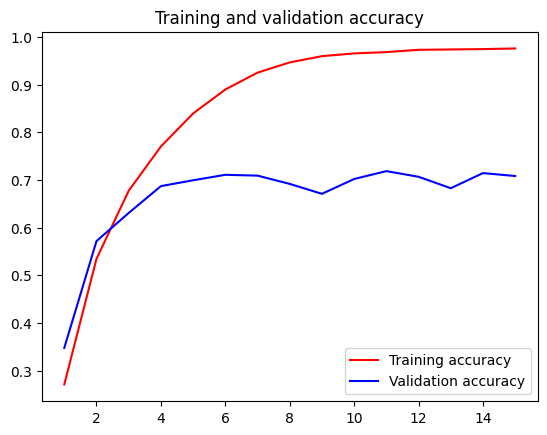

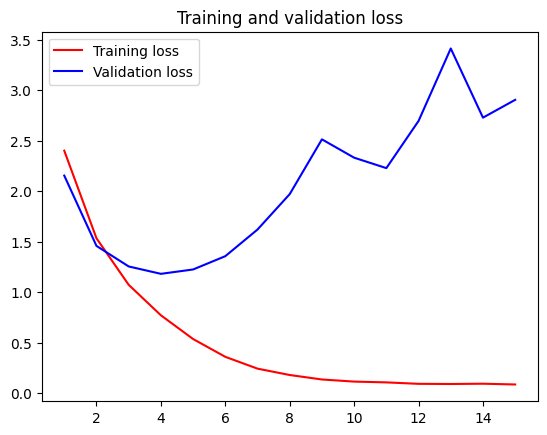

In [ ]:
plot_curves(hist_sequential1)

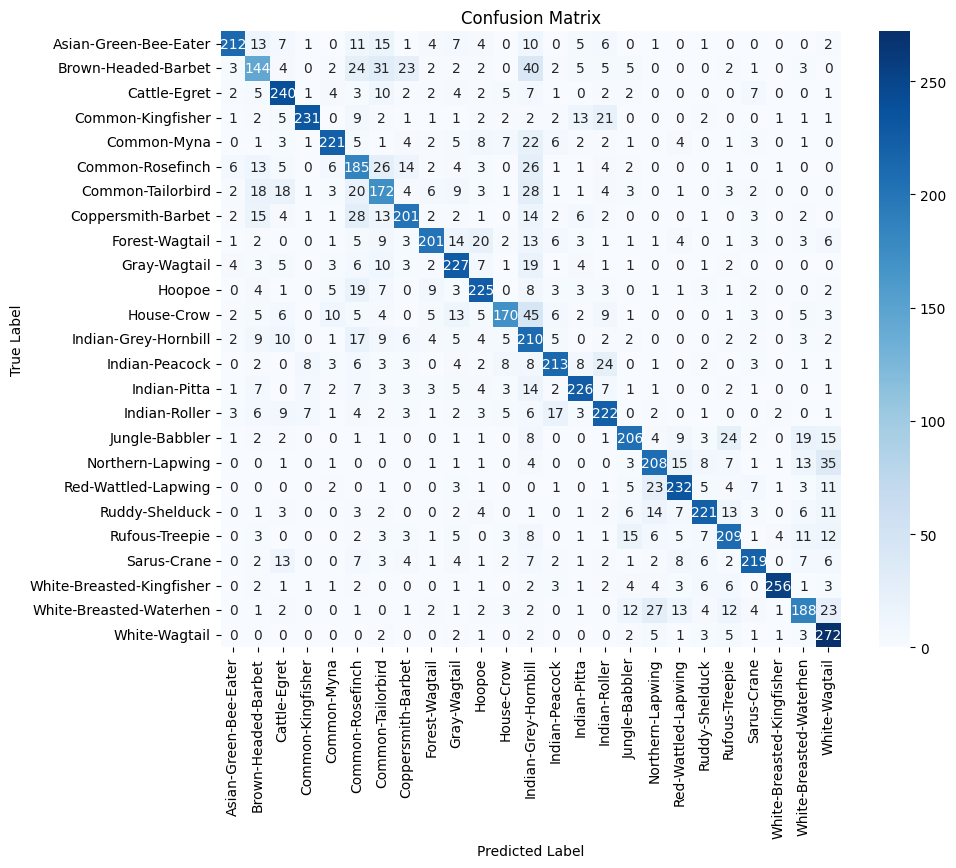

In [ ]:
plot_matriz_confusao(model_sequential1, val_ds)

#CNN com Dropout e MaxPooling

A introdução das técnicas de Dropout e Maxpooling manteve uma acurácia de 0,94 no treino, mas a acurácia de validação subiu para 0,72. Isso indica que, embora as técnicas usadas ajudem a mitigar o overfitting durante o treinamento, a rede ainda enfrenta dificuldades em generalizar nos dados de validação, possivelmente devido à complexidade do problema, à necessidade de ajustes mais refinados nos hiperparâmetros, ou a uma regularização mais rigorosa.

## Definindo o Modelo

In [ ]:
model_sequential2 = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),

    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.Dropout(0.2),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.Dropout(0.2),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.Dropout(0.3),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(256, (3, 3), activation="relu"),
    layers.Dropout(0.5),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(25, activation="softmax")
])


model_sequential2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 dropout (Dropout)           (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 dropout_1 (Dropout)         (None, 87, 87, 64)        0         
                                                      

## Treinamento

In [ ]:
model_sequential2.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

hist_sequential2 = model_sequential2.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15
469/469 [==============================] - 297s 632ms/step - loss: 2.4324 - accuracy: 0.2766 - val_loss: 2.1091 - val_accuracy: 0.4249
Epoch 2/15
469/469 [==============================] - 283s 603ms/step - loss: 1.5198 - accuracy: 0.5393 - val_loss: 1.6766 - val_accuracy: 0.5805
Epoch 3/15
469/469 [==============================] - 284s 605ms/step - loss: 1.1252 - accuracy: 0.6630 - val_loss: 1.4012 - val_accuracy: 0.6345
Epoch 4/15
469/469 [==============================] - 286s 609ms/step - loss: 0.8688 - accuracy: 0.7379 - val_loss: 1.2481 - val_accuracy: 0.6892
Epoch 5/15
469/469 [==============================] - 284s 606ms/step - loss: 0.6790 - accuracy: 0.7945 - val_loss: 1.1695 - val_accuracy: 0.6699
Epoch 6/15
469/469 [==============================] - 286s 611ms/step - loss: 0.5479 - accuracy: 0.8338 - val_loss: 1.0198 - val_accuracy: 0.7299
Epoch 7/15
469/469 [==============================] - 287s 613ms/step - loss: 0.4417 - accuracy: 0.8644 - val_loss: 1.1338 -

## Curvas de Acurácia e Perda

In [ ]:
plot_curves(hist_sequential2)

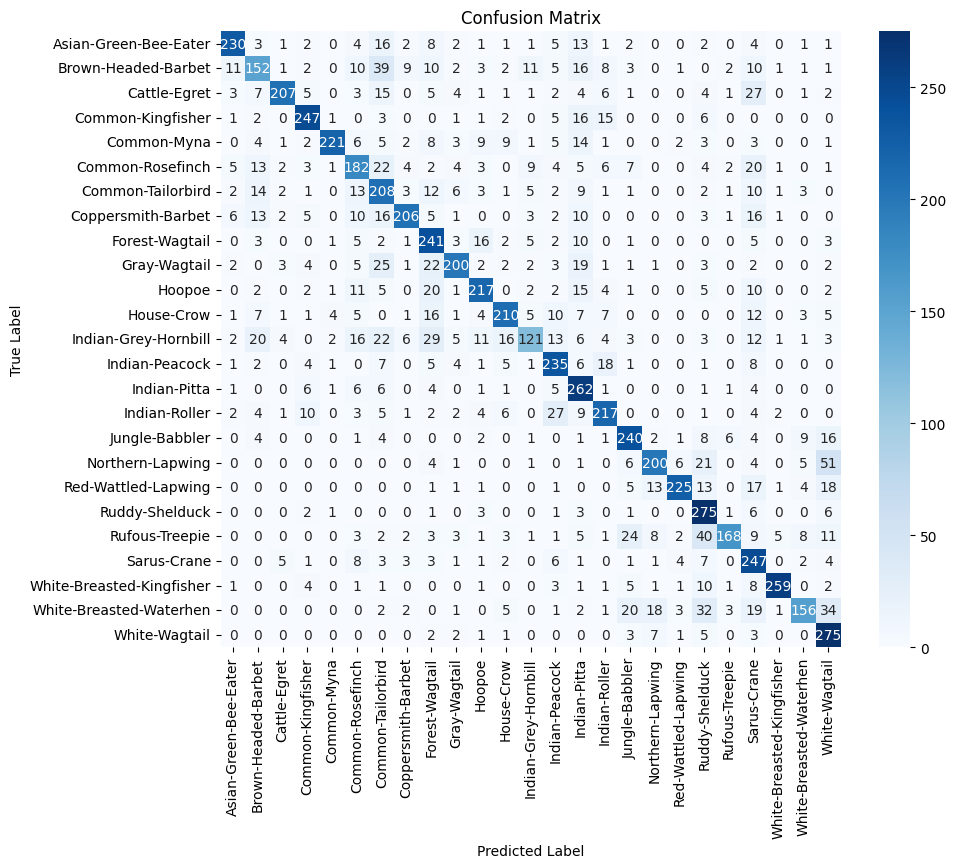

In [ ]:
plot_matriz_confusao(model_sequential2, val_ds)

# CNN com Dropout, MaxPooling, L1 e L2

A combinação de técnicas resultou em uma acurácia de 0.90 no treino e uma acurácia de validação de 0.83, tendo o melhor desempenho entre os modelos gerados, mas pouco distante do Spatial Dropout. A presença de múltiplas técnicas de regularização proporcionou uma melhoria no desempenho em relação ao modelo CNN puro e ao CNN apenas com Dropout e MaxPooling, a distância entre os valores de treino e validação, apesar do alto desempenho, parecem indicar uma leve tendêncica do modelo a overfitting.

## Definindo o Modelo

In [ ]:
checkpoint_filepath = '/content/working/L1L2_model.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
model_sequential3 = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),

    layers.Conv2D(32, (3, 3), activation="relu", kernel_regularizer=keras.regularizers.L1L2()),
    layers.Dropout(0.2),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu", kernel_regularizer=keras.regularizers.L1L2()),
    layers.Dropout(0.2),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.Dropout(0.3),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(256, (3, 3), activation="relu"),
    layers.Dropout(0.5),

    layers.GlobalMaxPooling2D(),

    layers.Dense(25, activation="softmax")
])

model_sequential3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 dropout_4 (Dropout)         (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 dropout_5 (Dropout)         (None, 87, 87, 64)        0         
                                                      

## Treinamento

In [ ]:
model_sequential3.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

hist_sequential3 = model_sequential3.fit(train_ds, epochs=15, validation_data=val_ds, callbacks=[model_checkpoint_callback])


Epoch 1/15
469/469 [==============================] - 301s 639ms/step - loss: 2.2540 - accuracy: 0.3076 - val_loss: 2.1725 - val_accuracy: 0.5255
Epoch 2/15
469/469 [==============================] - 286s 609ms/step - loss: 1.3844 - accuracy: 0.5789 - val_loss: 1.8724 - val_accuracy: 0.5907
Epoch 3/15
469/469 [==============================] - 284s 605ms/step - loss: 1.0407 - accuracy: 0.6868 - val_loss: 1.5062 - val_accuracy: 0.6729
Epoch 4/15
469/469 [==============================] - 286s 611ms/step - loss: 0.8502 - accuracy: 0.7425 - val_loss: 1.3467 - val_accuracy: 0.7640
Epoch 5/15
469/469 [==============================] - 288s 614ms/step - loss: 0.7268 - accuracy: 0.7799 - val_loss: 1.1353 - val_accuracy: 0.7931
Epoch 6/15
469/469 [==============================] - 288s 613ms/step - loss: 0.6362 - accuracy: 0.8079 - val_loss: 1.1567 - val_accuracy: 0.7925
Epoch 7/15
469/469 [==============================] - 287s 612ms/step - loss: 0.5632 - accuracy: 0.8281 - val_loss: 0.9489 -

## Curvas de Acurácia e Perda

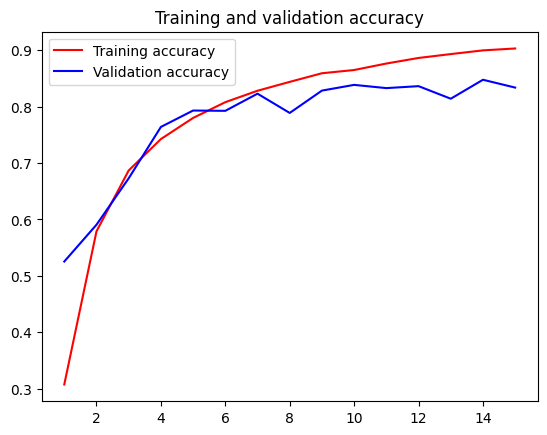

In [ ]:
plot_curves(hist_sequential3)

In [ ]:
plot_matriz_confusao(model_sequential3,val_ds)

# CNN com Spatial Dropout, MaxPooling, L1 e L2

O modelo que utilizou Spatial Dropout juntamente com outras técnicas de regularização apresentou uma acurácia de 0,82 no treino e de 0,84 na validação. A proximidade entre essas acurácias indica que o Spatial Dropout atuou bem como regularizador, evitando o overfitting do modelo. O desempenho foi muito próximo ao modelo com múltiplas técnicas de regularização e Dropout comum, porém com menor diferença entre o erro de treino e o de teste. Isso sugere que a estratégia do Spatial Dropout de desativar canais inteiros foi mais eficaz para evitar o overfitting. Como a acurácia no treino não atingiu valores muito altos (>0,9), pode-se levantar a hipótese de que, com mais epochs, o desempenho do modelo superaria os demais sem atingir o overfitting.

## Definindo o Modelo

In [ ]:
checkpoint_filepath = '/content/working/spatial_model.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
model_sequential4 = keras.Sequential([
    layers.Input(shape=(180, 180, 3)),
    layers.Rescaling(1./255),

    layers.Conv2D(32, (3, 3), activation="relu", kernel_regularizer=keras.regularizers.L1L2()),
    layers.SpatialDropout2D(0.1),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu", kernel_regularizer=keras.regularizers.L1L2()),
    layers.SpatialDropout2D(0.1),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.SpatialDropout2D(0.2),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(256, (3, 3), activation="relu"),
    layers.SpatialDropout2D(0.2),

    layers.GlobalMaxPooling2D(),
    layers.Dense(25, activation="softmax")
])

model_sequential4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 spatial_dropout2d (Spatial  (None, 178, 178, 32)      0         
 Dropout2D)                                                      
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 spatial_dropout2d_1 (Spati  (None, 87, 87, 64)        0

## Treinamento

In [ ]:
model_sequential4.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

hist_sequential4 = model_sequential4.fit(train_ds, epochs=15, validation_data=val_ds, callbacks=[model_checkpoint_callback])

Epoch 1/15
469/469 [==============================] - 253s 536ms/step - loss: 2.6604 - accuracy: 0.1649 - val_loss: 2.0951 - val_accuracy: 0.3649
Epoch 2/15
469/469 [==============================] - 247s 526ms/step - loss: 1.8948 - accuracy: 0.4176 - val_loss: 1.4417 - val_accuracy: 0.5655
Epoch 3/15
469/469 [==============================] - 244s 521ms/step - loss: 1.4932 - accuracy: 0.5519 - val_loss: 1.1318 - val_accuracy: 0.6680
Epoch 4/15
469/469 [==============================] - 245s 523ms/step - loss: 1.2664 - accuracy: 0.6186 - val_loss: 1.0066 - val_accuracy: 0.7080
Epoch 5/15
469/469 [==============================] - 245s 522ms/step - loss: 1.1137 - accuracy: 0.6680 - val_loss: 0.8560 - val_accuracy: 0.7569
Epoch 6/15
469/469 [==============================] - 248s 529ms/step - loss: 1.0194 - accuracy: 0.6999 - val_loss: 0.7664 - val_accuracy: 0.7789
Epoch 7/15
469/469 [==============================] - 247s 527ms/step - loss: 0.9236 - accuracy: 0.7235 - val_loss: 0.7341 -

## Curvas de Acurácia e Perda

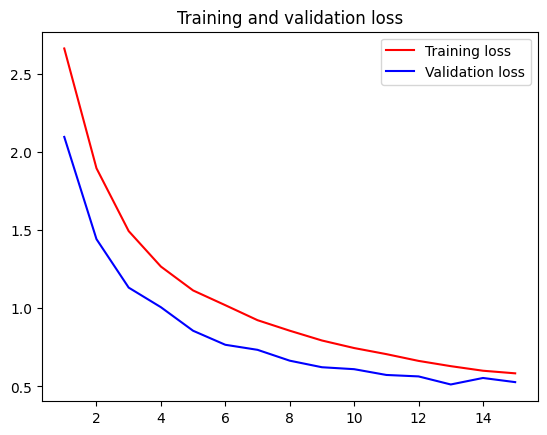

In [ ]:
plot_curves(hist_sequential4)

## Matriz de Confusão

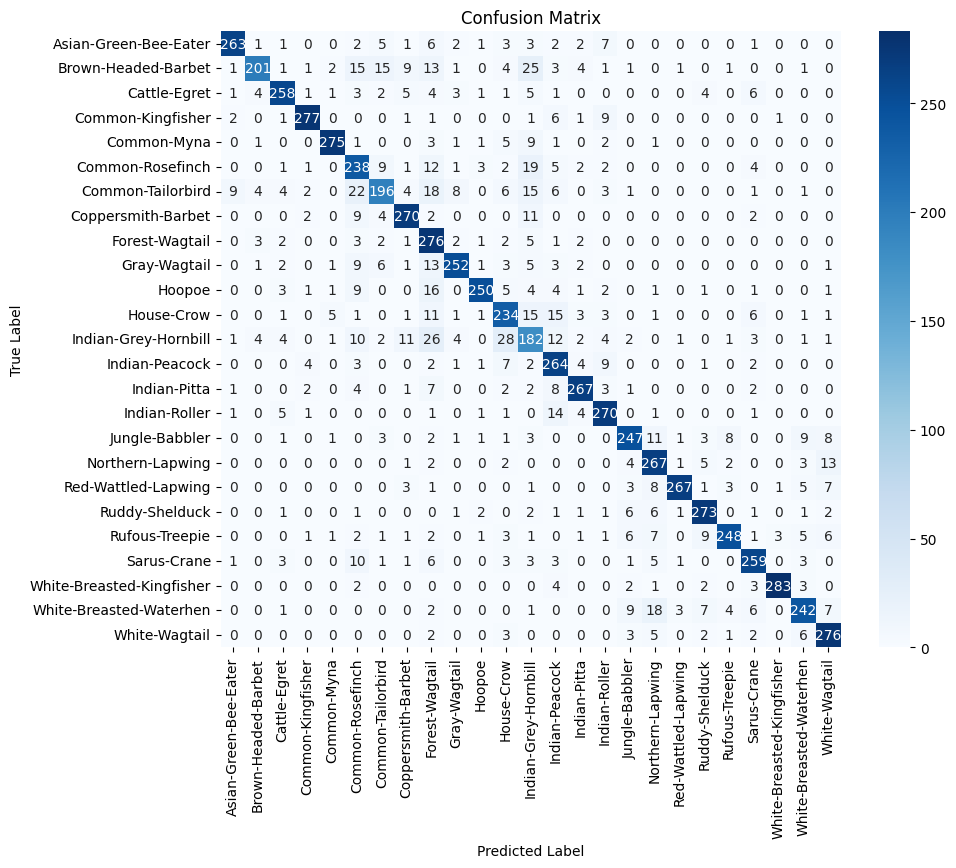

In [ ]:
plot_matriz_confusao(model_sequential4, val_ds)

# Conclusões

Os resultados indicam que a CNN "pura" sem o uso de técnicas de regularização, demonstrou baixa capacidade de generalização, indicando overfitting. As combinações de técnicas de regularização, como Dropout, MaxPooling e L1/L2, tiveram um impacto forte no desempenho, sugerindo que ajustes cuidadosos nos hiperparâmetros e na estrutura da rede são cruciais para otimizar a performance em problemas complexos de classificação. A aplicação de múltiplas técnicas de regularização nessa situação foi significativamente benéfica, mas deve ser feita com cautela para evitar a perda de informações críticas e a deterioração da capacidade de generalização do modelo.
A proximidade entre os valores das CNN com Dropout e Spatial Dropout, indica que as técnicas possuem uma efetividade similar. Seria interessante repetir o treinamento desses modelos para mais épocas e verificar se a acurácia permanece próxima, ou alguma das técnicas se irá se sobressair.